In [1]:
import pickle, random
from pathlib import Path

In [ ]:
!pip -q uninstall -y numpy matplotlib
!pip -q install "numpy<2" "matplotlib<3.9"

In [2]:
import matplotlib.pyplot as plt
import numpy as np

In [3]:
DATA_ROOT = '/kaggle/input/karsl-final-dataset/karsl_medical_emergencies_signbart'

In [4]:
root = DATA_ROOT
for split in ['train', 'val', 'test']:
    print(split, len(list(Path(root, split).rglob('*.pkl'))))

train 2620
val 1310
test 2957


In [5]:
!git clone https://github.com/tinh2044/SignBart.git
%cd SignBart
!pip -q install -r requirements.txt
!ls

fatal: destination path 'SignBart' already exists and is not an empty directory.
/kaggle/working/SignBart
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
mkl-umath 0.1.1 requires numpy<1.27.0,>=1.26.4, but you have numpy 2.2.6 which is incompatible.
mkl-random 1.2.4 requires numpy<1.27.0,>=1.26.4, but you have numpy 2.2.6 which is incompatible.
mkl-fft 1.3.8 requires numpy<1.27.0,>=1.26.4, but you have numpy 2.2.6 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.2.6 which is incompatible.
datasets 4.4.1 requires pyarrow>=21.0.0, but you have pyarrow 19.0.1 which is incompatible.
ydata-profiling 4.17.0 requires numpy<2.2,>=1.16.0, but you have numpy 2.2.6 which is incompatible.
google-colab 1.0.0 requires notebook==6.5.7, but you hav

In [6]:
!sed -n '1,220p' dataset.py

import json
import pickle

import numpy as np
import torch
import os
from .augmentations import rotate_keypoints, noise_injection, clip_frame, time_warp_uniform, flip_keypoints

class Datasets(torch.utils.data.Dataset):
    def __init__(self, root, split, shuffle=True, joint_idxs=None, augment=False):
        self.root = root
        self.split = split
        self.joint_idxs = joint_idxs
        self.augment = augment
        with open(f"{self.root}/label2id.json", 'r') as f:
            self.label2id = json.load(f)

        with open(f"{self.root}/id2label.json", 'r') as f:
            self.id2label = json.load(f)

        self.data_dir = f"{root}/{split}"

        self.list_key = [f"{self.data_dir}/{x}/{y}"
                         for x in os.listdir(self.data_dir)
                         for y in os.listdir(f"{self.data_dir}/{x}")
                         ]

        if shuffle:
            np.random.shuffle(self.list_key)

    def __getitem__(self, i):
        key = self.list_key

In [7]:
!grep -n "label = self.label2id" -n /kaggle/working/SignBart/dataset.py
!sed -n '30,55p' /kaggle/working/SignBart/dataset.py

44:        label = self.label2id[m.group(1)]

    def __getitem__(self, i):
        key = self.list_key[i]
        with open(key, "rb") as f:
            sample = pickle.load(f)

        keypoints = np.array(sample['keypoints'])[:, :, :2]
        keypoints = keypoints[:, :, :2]
        # assert removed (class derived from filename)
        import re
        fname = os.path.basename(key)
        m = re.search(r"_(\d{4})_", fname)
        if not m:
            raise ValueError(f"Cannot extract class id from filename: {fname}")
        label = self.label2id[m.group(1)]

        keypoints = np.clip(keypoints, 0, 1)
        if keypoints.shape[0] > 64:
            keypoints = clip_frame(keypoints, 64, True)

        if self.augment and np.random.uniform(0, 1) < 0.4:
            keypoints = self.apply_augment(keypoints)

        keypoints = self.normalize_keypoints(keypoints)

        keypoints = torch.from_numpy(keypoints).float()


In [8]:
path = "/kaggle/working/SignBart/dataset.py"

with open(path, "r", encoding="utf-8") as f:
    s = f.read()

#remove the assert - it used to cause crash :( something with sample['class']
s = s.replace(
    "        assert sample['class'] == key.split(\"/\")[-2], f\"{sample['class']} != {key.split('/')[-2]}\"\n",
    "        # assert removed (class derived from filename)\n"
)

#replace label assign - searching for something that match our class (4 digits like 0071)
s = s.replace(
    "        label = self.label2id[sample['class']]\n",
    "        import re\n"
    "        fname = os.path.basename(key)\n"
    "        m = re.search(r\"_(\\d{4})_\", fname)\n"
    "        if not m:\n"
    "            raise ValueError(f\"Cannot extract class id from filename: {fname}\")\n"
    "        label = self.label2id[m.group(1)]\n"
)

with open(path, 'w', encoding = 'utf-8') as f:
    f.write(s)

print('dataset.py patched')


dataset.py patched


In [9]:
!touch /kaggle/working/SignBart/__init__.py

In [ ]:
############!!!!!!! I run this once then restart kernel - this changed the way og importing - made it pakage style instead of script style
!sed -i \
-e 's/^from utils import /from .utils import /' \
-e 's/^from encoder import /from .encoder import /' \
-e 's/^from decoder import /from .decoder import /' \
-e 's/^from layers import /from .layers import /' \
-e 's/^from attention import /from .attention import /' \
-e 's/^from augmentations import /from .augmentations import /' \
-e 's/^from dataset import /from .dataset import /' \
-e 's/^from model import /from .model import /' \
/kaggle/working/SignBart/{decoder.py,model.py,encoder.py,attention.py,layers.py,dataset.py,main.py}

In [10]:
import sys
sys.path.append("/kaggle/working")
#looking for packages from /kaggle/working - that h
from SignBart.dataset import Datasets

In [11]:
#JOINT_IDXS = list(range(75))
JOINT_IDXS = [
    list(range(0, 33)), #pose
    list(range(33, 54)), #left hand
    list(range(54, 75)), #right hand
]

#shuffling in train dataset only - also augmentation
train_ds = Datasets(DATA_ROOT, 'train', shuffle = True, joint_idxs = JOINT_IDXS, augment = True)
val_ds = Datasets(DATA_ROOT, 'val', shuffle = False, joint_idxs = JOINT_IDXS, augment = False)
test_ds = Datasets(DATA_ROOT, 'test', shuffle = False, joint_idxs = JOINT_IDXS, augment = False)

x, y = train_ds[0] #load one pkl file and go through augmentation (train_ds)
print("One sample:", x.shape, y) #return (T, 75, 2)
print("label2id size:", len(train_ds.label2id)) #this is our classes which are the classifier dim!
print('Train siz: ', len(train_ds))
print('Val size: ', len(val_ds))
print('Test size: ', len(test_ds))

One sample: torch.Size([67, 75, 2]) tensor(20)
label2id size: 131
Train siz:  2620
Val size:  1310
Test size:  2957


In [12]:
import torch

FIX_T = 50 #PyTorch can not stack tensors of different T (frames) into batch
#This custom function enforce fix T , although I have done padding but this to ensure

def collate_fixed_T(batch):
    #x[0] is (T, 75, 2) while x[1] is label
    keypoints = [x[0] for x in batch] #list of tensors - T may vary 
    labels = torch.stack([x[1] for x in batch])

    kp_out, attn_out = [], []
    for kp in keypoints: #for each sample crop or pad to 50 frames
        T = kp.shape[0]
        if T >= FIX_T:
            kp2 = kp[:FIX_T]
            mask = torch.ones(FIX_T) #attention mask all 1 meaning all farmes real
        else:
            pad = kp[-1:].repeat(FIX_T - T, 1, 1) #pad using last frame
            kp2 = torch.cat([kp, pad], dim = 0)
            mask = torch.cat([torch.ones(T), torch.zeros(FIX_T - T)], dim = 0) #first T are 1 but reamining are 0 - padded

        kp_out.append(kp2)
        attn_out.append(mask)

    return {
        'keypoints': torch.stack(kp_out), # B,50,75,2)
        'attention_mask': torch.stack(attn_out), #(B,50)
        'labels': labels #(B,)
    }


In [13]:
from torch.utils.data import DataLoader

BATCH_SIZE = 64
#NUM_WORKERS = 2 #used it earlier but cancel due to the crash

#shuffling samples each epoch
train_loader = DataLoader(train_ds, batch_size = BATCH_SIZE, shuffle = True,
                          num_workers = 0, pin_memory = False,
                          collate_fn = collate_fixed_T)

val_loader = DataLoader(val_ds, batch_size = BATCH_SIZE, shuffle = False,
                        num_workers = 0, pin_memory = False,
                        collate_fn = collate_fixed_T)

test_loader = DataLoader(test_ds, batch_size = BATCH_SIZE, shuffle = False,
                         num_workers = 0, pin_memory = False,
                         collate_fn = collate_fixed_T)

#checking a batch early before training
batch = next(iter(train_loader))
print('keypoints: ', batch['keypoints'].shape, 'mask: ', batch['attention_mask'].shape)
print('labels min/max: ', batch['labels'].min().item(),'/', batch['labels'].max().item())

keypoints:  torch.Size([64, 50, 75, 2]) mask:  torch.Size([64, 50])
labels min/max:  0 / 128


In [15]:
#checking existing configuration
!ls configs

ASL-Citizen-1000.yaml  KArSL02-100.yaml      KArSL-ALL-100.yaml
ASL-Citizen-100.yaml   KArSL02-190.yaml      KArSL-ALL-502.yaml
ASL-Citizen-200.yaml   KArSL02-502.yaml      LSA-64.yaml
ASL-Citizen-400.yaml   KArSL02-ALL-190.yaml  WLASL-1000.yaml
KArSL01-100.yaml       KArSL03-100.yaml      WLASL-100.yaml
KArSL01-190.yaml       KArSL03-190.yaml      WLASL-2000.yaml
KArSL01-502.yaml       KArSL03-502.yaml      WLASL-300.yaml


In [16]:
cp configs/KArSL-ALL-100.yaml configs/KArSL-MEDICAL-131.yaml

In [17]:
import yaml, torch
from SignBart.model import SignBart

CFG = '/kaggle/working/SignBart/configs/KArSL-MEDICAL-131.yaml'
with open(CFG, "r") as f:
    cfg = yaml.safe_load(f)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#building the model
net = SignBart(cfg).to(device).eval()

print('Device:', device)
print('cfg num_labels:', cfg.get('num_labels')) #check num of classes - should be 131 for us

Device: cuda
cfg num_labels: 100


In [18]:
batch = next(iter(train_loader))
batch = {k: v.to(device) for k, v in batch.items()}

nolabel = {
    'keypoints': batch["keypoints"],
    'attention_mask': batch["attention_mask"],
    'labels': None
}

with torch.no_grad():
    out = net(**nolabel)

logits = out[1] 
print("logits:", logits.shape)  #[B, 100] currently WRONG

logits: torch.Size([64, 100])


In [19]:
import torch.nn as nn

cands = []
#looping over modules in the model
for p, m in net.named_modules(): 
    if isinstance(m, nn.Linear) and m.out_features == 100: #filtering
        cands.append((p, m.in_features, m.out_features)) #store the filtered module path/name and in/out features

print('Linear layers with out_features = 100:' )
for x in cands:
    print(x,'\n')

#this to make sure if NO 100 output features head is found
assert len(cands) > 0, 'No 100 class head found to patch'
head_name, in_f, _ = cands[-1]  #-1 > pick last 100 head ,, usually classifier but because it is deep this to verify
print('\nChosen head', head_name, f'{in_f} > 131') 

Linear layers with out_features = 100:
('classification_head.out_proj', 128, 100) 


Chosen head classification_head.out_proj 128 > 131


In [20]:
#passing module path then replace the target module
def set_module_by_name(root, name, new_module):
    parent = root
    parts = name.split(".")
    for p in parts[:-1]:
        parent = getattr(parent, p)
    setattr(parent, parts[-1], new_module)

old_head = dict(net.named_modules())[head_name] #dict to map module names to modules - extracting the layer from before [head_name]
#creating new classifier head
new_head = nn.Linear(in_f, 131).to(device = device, dtype = old_head.weight.dtype)

set_module_by_name(net, head_name, new_head) #replacing the head
print('Patched:', head_name)

Patched: classification_head.out_proj


In [21]:
#checking again
net.eval()
with torch.no_grad():
    out = net(**nolabel)
logits = out[1]
print('logits:', logits.shape)  #[B, 131] A MUST!!!!!! 

logits: torch.Size([64, 131])


In [ ]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

net = net.to(device)

b = next(iter(train_loader))
b = {k: v.to(device) for k, v in b.items()}

print(b["keypoints"].dtype, b["attention_mask"].dtype, b["labels"].dtype)
print(b["labels"].min().item(), b["labels"].max().item())

In [ ]:
batch = next(iter(train_loader))

labels = batch["labels"]          # stays on CPU
print("labels dtype:", labels.dtype)
print("min label:", labels.min().item(), "max label:", labels.max().item())
print("num_labels expected:", 131)
print("unique sample:", torch.unique(labels)[:20])

In [ ]:
kp = batch["keypoints"]
print("keypoints shape:", kp.shape)
print("nan count:", torch.isnan(kp).sum().item())
print("inf count:", torch.isinf(kp).sum().item())

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = net.to(device)

In [22]:
!find /kaggle -name "*.pth" #NO BACKBONE WEIGHTS

In [23]:
import torch
import torch.nn

optimizer = torch.optim.AdamW(
    net.parameters(),
    lr = 3e-4, # default for SignBart
    weight_decay = 1e-2
)

In [24]:
import torch.nn.functional as F

net.train()

EPOCHS = 200
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = EPOCHS)

In [27]:
import os
from tqdm import tqdm

CHECK_P_DIR = '/kaggle/working/checkpoints'
os.makedirs(CHECK_P_DIR, exist_ok = True)
SAVE_PATH = os.path.join(CHECK_P_DIR, 'signbart_medical_131_best.pth')

def forward_logits(model, batch):
    # model returns (loss, logits) in this repo
    out = model(**batch)
    return out[1]

@torch.no_grad()
def eval_epoch(model, loader, device):
    model.eval()
    total, correct, total_loss = 0, 0, 0.0

    for batch in tqdm(loader, leave = False):
        batch = {k: v.to(device) for k, v in batch.items()}
        labels = batch['labels']

        nolabel = {k: v for k, v in batch.items()}
        nolabel['labels'] = None

        logits = forward_logits(model, nolabel)
        loss = F.cross_entropy(logits, labels)

        pred = logits.argmax(dim = 1)
        correct += (pred == labels).sum().item()
        total += labels.size(0)
        total_loss += loss.item() * labels.size(0)

    return total_loss / total, correct / total

def train_epoch(model, loader, optimizer, device):
    model.train()
    total, correct, total_loss = 0, 0, 0.0

    for batch in tqdm(loader, leave = False):
        batch = {k: v.to(device) for k, v in batch.items()}
        labels = batch['labels']
        
        nolabel = batch.copy()
        nolabel['labels'] = None

        optimizer.zero_grad(set_to_none = True)
        logits = forward_logits(model, nolabel)
        loss = F.cross_entropy(logits, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        pred = logits.argmax(dim = 1)
        correct += (pred == labels).sum().item()
        total += labels.size(0)
        total_loss += loss.item() * labels.size(0)

    return total_loss / total, correct / total

device = next(net.parameters()).device
print('device:', device)

best_val_acc = -1.0 #to save first epoch if it is 0 :)
best_state = None
patience = 15
bad = 0

for epoch in range(1, EPOCHS+1):
    tr_loss, tr_acc = train_epoch(net, train_loader, optimizer, device)
    va_loss, va_acc = eval_epoch(net, val_loader, device)
    scheduler.step()

    print(f'Epoch {epoch:03d} | train acc {tr_acc:.4f} loss {tr_loss:.4f} | val acc {va_acc:.4f} loss {va_loss:.4f}')

    if va_acc > best_val_acc:
        best_val_acc = va_acc

        #save best model to disk
        torch.save(net.state_dict(), SAVE_PATH)
        print(f'saved best model :) >> {SAVE_PATH}')

        #keep best weights
        best_state = {k: v.detach().cpu().clone() for k, v in net.state_dict().items()}

        bad = 0
        print('new best')
    else:
        bad += 1
        if bad >= patience:
            print(f'Early Stopping. Best val acc = {best_val_acc:.4f}')
            break

#restore best
if best_state is not None:
    net.load_state_dict(best_state)
    
net.to(device)

device: cuda:0


Epoch 001 | train acc 0.0069 loss 5.0484 | val acc 0.0282 loss 4.8174
saved best model :) >> /kaggle/working/checkpoints/signbart_medical_131_best.pth
new best


Epoch 002 | train acc 0.0156 loss 4.8796 | val acc 0.0511 loss 4.6541
saved best model :) >> /kaggle/working/checkpoints/signbart_medical_131_best.pth
new best


Epoch 003 | train acc 0.0363 loss 4.6042 | val acc 0.0756 loss 4.4054
saved best model :) >> /kaggle/working/checkpoints/signbart_medical_131_best.pth
new best


Epoch 004 | train acc 0.0702 loss 4.2559 | val acc 0.1305 loss 4.1267
saved best model :) >> /kaggle/working/checkpoints/signbart_medical_131_best.pth
new best


Epoch 005 | train acc 0.1023 loss 3.9661 | val acc 0.1802 loss 3.9593
saved best model :) >> /kaggle/working/checkpoints/signbart_medical_131_best.pth
new best


Epoch 006 | train acc 0.1622 loss 3.7045 | val acc 0.2351 loss 3.7344
saved best model :) >> /kaggle/working/checkpoints/signbart_medical_131_best.pth
new best


Epoch 007 | train acc 0.2088 loss 3.4741 | val acc 0.2656 loss 3.5002
saved best model :) >> /kaggle/working/checkpoints/signbart_medical_131_best.pth
new best


Epoch 008 | train acc 0.2740 loss 3.2330 | val acc 0.2992 loss 3.3253
saved best model :) >> /kaggle/working/checkpoints/signbart_medical_131_best.pth
new best


Epoch 009 | train acc 0.3317 loss 3.0001 | val acc 0.3374 loss 3.1039
saved best model :) >> /kaggle/working/checkpoints/signbart_medical_131_best.pth
new best


Epoch 010 | train acc 0.3844 loss 2.8184 | val acc 0.3733 loss 2.9236
saved best model :) >> /kaggle/working/checkpoints/signbart_medical_131_best.pth
new best


Epoch 011 | train acc 0.4405 loss 2.6117 | val acc 0.3794 loss 2.7804
saved best model :) >> /kaggle/working/checkpoints/signbart_medical_131_best.pth
new best


Epoch 012 | train acc 0.4756 loss 2.4478 | val acc 0.4290 loss 2.5902
saved best model :) >> /kaggle/working/checkpoints/signbart_medical_131_best.pth
new best


Epoch 013 | train acc 0.5336 loss 2.2288 | val acc 0.4496 loss 2.4362
saved best model :) >> /kaggle/working/checkpoints/signbart_medical_131_best.pth
new best


Epoch 014 | train acc 0.5851 loss 2.0609 | val acc 0.5099 loss 2.3028
saved best model :) >> /kaggle/working/checkpoints/signbart_medical_131_best.pth
new best


Epoch 015 | train acc 0.6183 loss 1.9023 | val acc 0.5252 loss 2.1586
saved best model :) >> /kaggle/working/checkpoints/signbart_medical_131_best.pth
new best


Epoch 016 | train acc 0.6523 loss 1.7663 | val acc 0.5366 loss 2.0394
saved best model :) >> /kaggle/working/checkpoints/signbart_medical_131_best.pth
new best


Epoch 017 | train acc 0.6866 loss 1.6114 | val acc 0.5618 loss 1.9538
saved best model :) >> /kaggle/working/checkpoints/signbart_medical_131_best.pth
new best


Epoch 018 | train acc 0.6954 loss 1.5152 | val acc 0.5748 loss 1.8797
saved best model :) >> /kaggle/working/checkpoints/signbart_medical_131_best.pth
new best


Epoch 019 | train acc 0.7405 loss 1.3282 | val acc 0.5947 loss 1.7535
saved best model :) >> /kaggle/working/checkpoints/signbart_medical_131_best.pth
new best


Epoch 020 | train acc 0.7599 loss 1.2555 | val acc 0.6053 loss 1.7371
saved best model :) >> /kaggle/working/checkpoints/signbart_medical_131_best.pth
new best


Epoch 021 | train acc 0.7553 loss 1.1795 | val acc 0.6137 loss 1.6598
saved best model :) >> /kaggle/working/checkpoints/signbart_medical_131_best.pth
new best


Epoch 022 | train acc 0.7802 loss 1.1181 | val acc 0.6015 loss 1.6279


Epoch 023 | train acc 0.8008 loss 1.0166 | val acc 0.6359 loss 1.5201
saved best model :) >> /kaggle/working/checkpoints/signbart_medical_131_best.pth
new best


Epoch 024 | train acc 0.8126 loss 0.9604 | val acc 0.6198 loss 1.5382


Epoch 025 | train acc 0.8160 loss 0.9162 | val acc 0.6275 loss 1.4881


Epoch 026 | train acc 0.8389 loss 0.8461 | val acc 0.6229 loss 1.4746


Epoch 027 | train acc 0.8485 loss 0.7994 | val acc 0.6145 loss 1.5330


Epoch 028 | train acc 0.8458 loss 0.7677 | val acc 0.6420 loss 1.4250
saved best model :) >> /kaggle/working/checkpoints/signbart_medical_131_best.pth
new best


Epoch 029 | train acc 0.8397 loss 0.7541 | val acc 0.6382 loss 1.4124


Epoch 030 | train acc 0.8546 loss 0.6914 | val acc 0.6550 loss 1.3717
saved best model :) >> /kaggle/working/checkpoints/signbart_medical_131_best.pth
new best


Epoch 031 | train acc 0.8725 loss 0.6315 | val acc 0.6473 loss 1.3693


Epoch 032 | train acc 0.8744 loss 0.6053 | val acc 0.6450 loss 1.3838


Epoch 033 | train acc 0.8630 loss 0.6143 | val acc 0.6435 loss 1.3554


Epoch 034 | train acc 0.8786 loss 0.5763 | val acc 0.6435 loss 1.3156


Epoch 035 | train acc 0.8939 loss 0.5180 | val acc 0.6748 loss 1.2921
saved best model :) >> /kaggle/working/checkpoints/signbart_medical_131_best.pth
new best


Epoch 036 | train acc 0.8779 loss 0.5472 | val acc 0.6565 loss 1.3206


Epoch 037 | train acc 0.8977 loss 0.5079 | val acc 0.6641 loss 1.2395


Epoch 038 | train acc 0.9000 loss 0.4702 | val acc 0.6473 loss 1.2815


Epoch 039 | train acc 0.8981 loss 0.4498 | val acc 0.6565 loss 1.2787


Epoch 040 | train acc 0.9015 loss 0.4510 | val acc 0.6550 loss 1.2864


Epoch 041 | train acc 0.8939 loss 0.4426 | val acc 0.6626 loss 1.2922


Epoch 042 | train acc 0.9065 loss 0.4137 | val acc 0.6733 loss 1.2088


Epoch 043 | train acc 0.9057 loss 0.4324 | val acc 0.6565 loss 1.2270


Epoch 044 | train acc 0.9134 loss 0.3973 | val acc 0.6649 loss 1.2563


Epoch 045 | train acc 0.9107 loss 0.3948 | val acc 0.6580 loss 1.2371


Epoch 046 | train acc 0.9134 loss 0.3707 | val acc 0.6611 loss 1.2201


Epoch 047 | train acc 0.9237 loss 0.3397 | val acc 0.6634 loss 1.2072


Epoch 048 | train acc 0.9214 loss 0.3375 | val acc 0.6511 loss 1.2593


Epoch 049 | train acc 0.9229 loss 0.3409 | val acc 0.6573 loss 1.2264


Epoch 050 | train acc 0.9103 loss 0.3557 | val acc 0.6595 loss 1.2441
Early Stopping. Best val acc = 0.6748


SignBart(
  (encoder): Encoder(
    (embed_positions): PositionalEmbedding(514, 128)
    (layers): ModuleList(
      (0-1): 2 x EncoderLayer(
        (self_attn): SelfAttention(
          (k_proj): Linear(in_features=128, out_features=128, bias=True)
          (v_proj): Linear(in_features=128, out_features=128, bias=True)
          (q_proj): Linear(in_features=128, out_features=128, bias=True)
          (out_proj): Linear(in_features=128, out_features=128, bias=True)
        )
        (self_attn_layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (activation_fn): GELU(approximate='none')
        (fc1): Linear(in_features=128, out_features=256, bias=True)
        (fc2): Linear(in_features=256, out_features=128, bias=True)
        (final_layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      )
    )
    (layernorm_embedding): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  )
  (decoder): Decoder(
    (embed_positions): PositionalEmbedding(

In [28]:
from torch.utils.data import DataLoader, Subset

#extracting signerIDs from file names
def signer_from_path(p):
    #filename like 01_03_01_0071 > signer 01
    fname = os.path.basename(p)
    return int(fname.split('_')[0]) #01_ > 01


#building a Dataloader for the signer to select samples based on the signer
#I will check signer dependent out of curiosity :)
def make_signer_loader_from_list_key(dataset, signer_id, base_loader):
    idxs = [i for i, p in enumerate(dataset.list_key) if signer_from_path(p) == signer_id]
    subset = Subset(dataset, idxs)

    #collate_fixed_T used here also
    loader = DataLoader(subset, batch_size = base_loader.batch_size, shuffle = False, num_workers = base_loader.num_workers, collate_fn=base_loader.collate_fn, pin_memory = True)

    print(f'Signer {signer_id:02d}: {len(subset)} samples')
    return loader

In [29]:
@torch.no_grad()
def collect_logits_labels(model, loader, device):
    model.eval()
    all_logits, all_labels = [], []
    for batch in tqdm(loader, leave=False):
        batch = {k: v.to(device) for k, v in batch.items()}
        labels = batch["labels"]
        nolabel = batch.copy()
        nolabel["labels"] = None
        out = model(**nolabel)
        logits = out[1]
        all_logits.append(logits.cpu())
        all_labels.append(labels.cpu())
    return torch.cat(all_logits, dim=0), torch.cat(all_labels, dim = 0)

In [30]:
def confusion_matrix_from_logits(logits, labels, num_classes: int):
    preds = logits.argmax(dim=1)
    cm = torch.zeros((num_classes, num_classes), dtype = torch.long)
    for t, p in zip(labels.tolist(), preds.tolist()):
        cm[t, p] += 1
    return cm

In [31]:
def metrics_from_cm(cm: torch.Tensor):
    #cm: [C, C]
    #rows are ground-truth/target ,,, cols are pred
    C = cm.size(0)
    tp = cm.diag().float()
    support = cm.sum(dim = 1).float() # per class true counts
    pred_count = cm.sum(dim = 0).float()# per class predicted counts

    fp = pred_count - tp #false positive
    fn = support - tp #false negative

    #calculation
    precision = tp / (tp + fp + 1e-12)
    recall = tp / (tp + fn + 1e-12)

    f1 = 2 * precision * recall / (precision + recall + 1e-12)

    #overall accuracy
    acc = tp.sum().item() / cm.sum().item()

    #avg accuracy = mean recall over classes that appear
    present = support > 0
    avg_acc = recall[present].mean().item() if present.any() else 0.0

    #macro-F1 over classes that appear
    macro_f1 = f1[present].mean().item() if present.any() else 0.0

    #micro-F1 for single-label multiclass equals accuracy
    micro_tp = tp.sum()
    micro_fp = fp.sum()
    micro_fn = fn.sum()
    micro_prec = micro_tp / (micro_tp + micro_fp + 1e-12)
    micro_rec = micro_tp / (micro_tp + micro_fn + 1e-12)
    micro_f1 = (2 * micro_prec * micro_rec / (micro_prec + micro_rec + 1e-12)).item()

    return {
        'Accuracy': acc,
        'Averaged Accuracy': avg_acc,
        'Micro-F1': micro_f1,
        'Macro-F1': macro_f1,
    }

In [48]:
def print_metrics(name: str, m: dict, N: int, C: int):
    print(f"\n{name}")
    print(" " * 34)
    print(f"Accuracy           : {m['Accuracy']:.4f}")
    print(f"Averaged Accuracy  : {m['Averaged Accuracy']:.4f}")
    print(f"Micro-F1           : {m['Micro-F1']:.4f}")
    print(f"Macro-F1           : {m['Macro-F1']:.4f}")

In [33]:
@torch.no_grad()
def eval_main_metrics(model, loader, device, num_classes: int, name = 'TEST'):
    logits, labels = collect_logits_labels(model, loader, device)
    cm = confusion_matrix_from_logits(logits, labels, num_classes)
    m = metrics_from_cm(cm)
    print_metrics(name, m, N=len(labels), C=num_classes)
    return {"logits": logits, "labels": labels, "cm": cm, "metrics": m}


In [41]:
NUM_CLASSES = 131
device = next(net.parameters()).device
print("Signer-Independent")
test_all = eval_main_metrics(net, test_loader, device, NUM_CLASSES, name = 'TEST (All signers)')

Signer-Independent

TEST (All signers)
                                  
Accuracy           : 0.8066
Averaged Accuracy  : 0.8095
Micro-F1           : 0.8066
Macro-F1           : 0.8055


In [49]:
def signer_ids_in_dataset(ds):
    return sorted({signer_from_path(p) for p in ds.list_key})

def signer_set(ds):
    return {signer_from_path(p) for p in ds.list_key}

train_signers = signer_set(train_ds) # seen during training
test_signers = signer_ids_in_dataset(test_ds) #unseen during training - only val

print("\nSigner-dependent evaluation on TEST:")
print("_" * 37)
print(f"Seen signers in TRAIN: {sorted(train_signers)}")
print(f"Signers in TEST      : {test_signers}")
print("_" * 37)

rows = []
for sid in test_signers:
    loader_s = make_signer_loader_from_list_key(test_ds, sid, test_loader)
    result_s = eval_main_metrics(net, loader_s, device, NUM_CLASSES, name=f"Signer {sid:02d}")
    tag = "SEEN" if sid in train_signers else "UNSEEN"
    m = result_s["metrics"]
    rows.append((sid, tag, len(result_s["labels"]), m["Accuracy"], m["Averaged Accuracy"], m["Micro-F1"], m["Macro-F1"]))


Signer-dependent evaluation on TEST:
_____________________________________
Seen signers in TRAIN: [1, 2]
Signers in TEST      : [1, 2, 3]
_____________________________________
Signer 01: 1048 samples



Signer 01
                                  
Accuracy           : 0.8798
Averaged Accuracy  : 0.8798
Micro-F1           : 0.8798
Macro-F1           : 0.8718
Signer 02: 1048 samples



Signer 02
                                  
Accuracy           : 0.8464
Averaged Accuracy  : 0.8460
Micro-F1           : 0.8464
Macro-F1           : 0.8399
Signer 03: 861 samples



Signer 03
                                  
Accuracy           : 0.6690
Averaged Accuracy  : 0.6701
Micro-F1           : 0.6690
Macro-F1           : 0.6532


In [ ]:
#summary table
print("\nSummary (per signer):")
print("-" * 85)
print(f"{'Signer':>6}  {'Seen?':>6}  {'N':>6}  {'Acc':>8}  {'AvgAcc':>8}  {'MicroF1':>8}  {'MacroF1':>8}")
print("-" * 85)
for sid, tag, n, acc, aacc, mi, ma in rows:
    print(f"{sid:6d}  {tag:>6}  {n:6d}  {acc:8.4f}  {aacc:8.4f}  {mi:8.4f}  {ma:8.4f}")
print("-" * 85)

seen_rows = [r for r in rows if r[1] == "SEEN"]
unseen_rows = [r for r in rows if r[1] == "UNSEEN"]

def weighted_mean(vals, weights):
    w = sum(weights)
    return sum(v*wt for v, wt in zip(vals, weights))/w if w > 0 else 0.0

for group_name, group in [("SEEN", seen_rows), ("UNSEEN", unseen_rows)]:
    Ns = [r[2] for r in group]
    if sum(Ns) == 0:
        continue
    acc  = weighted_mean([r[3] for r in group], Ns)
    aacc = weighted_mean([r[4] for r in group], Ns)
    mi   = weighted_mean([r[5] for r in group], Ns)
    ma   = weighted_mean([r[6] for r in group], Ns)
    print(f"\n{group_name}  (sample-weighted): N={sum(Ns)} | Acc={acc:.4f} | AvgAcc={aacc:.4f} | MicroF1={mi:.4f} | MacroF1={ma:.4f}")


Summary (per signer):
-------------------------------------------------------------------------------------
Signer   Seen?       N       Acc    AvgAcc   MicroF1   MacroF1
-------------------------------------------------------------------------------------
     1    SEEN    1048    0.8798    0.8798    0.8798    0.8718
     2    SEEN    1048    0.8464    0.8460    0.8464    0.8399
     3  UNSEEN     861    0.6690    0.6701    0.6690    0.6532
-------------------------------------------------------------------------------------

SEEN  (sample-weighted): N=2096 | Acc=0.8631 | AvgAcc=0.8629 | MicroF1=0.8631 | MacroF1=0.8559

UNSEEN  (sample-weighted): N=861 | Acc=0.6690 | AvgAcc=0.6701 | MicroF1=0.6690 | MacroF1=0.6532


CM shape: torch.Size([131, 131])
Confusion matrix (raw counts):
tensor([[19,  0,  0,  ...,  0,  0,  0],
        [ 0, 21,  0,  ...,  0,  2,  0],
        [ 0,  0, 24,  ...,  0,  0,  0],
        ...,
        [ 0,  0,  0,  ..., 24,  0,  0],
        [ 0,  0,  0,  ...,  0, 24,  0],
        [ 0,  0,  0,  ...,  0,  0, 20]])


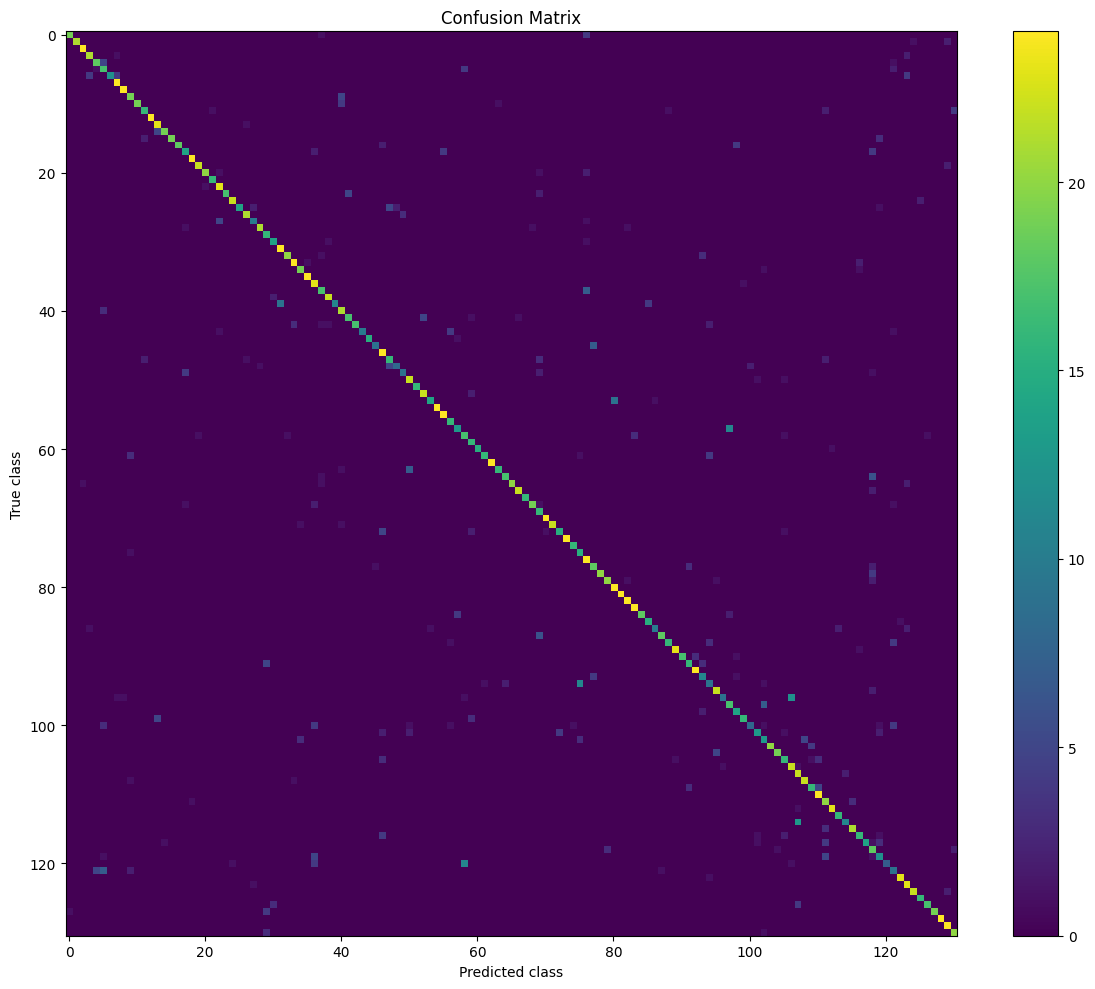

Saved:
 - /kaggle/working/TEST_ALL_cm.pt
 - /kaggle/working/TEST_ALL_cm.csv
 - /kaggle/working/TEST_ALL_cm.png


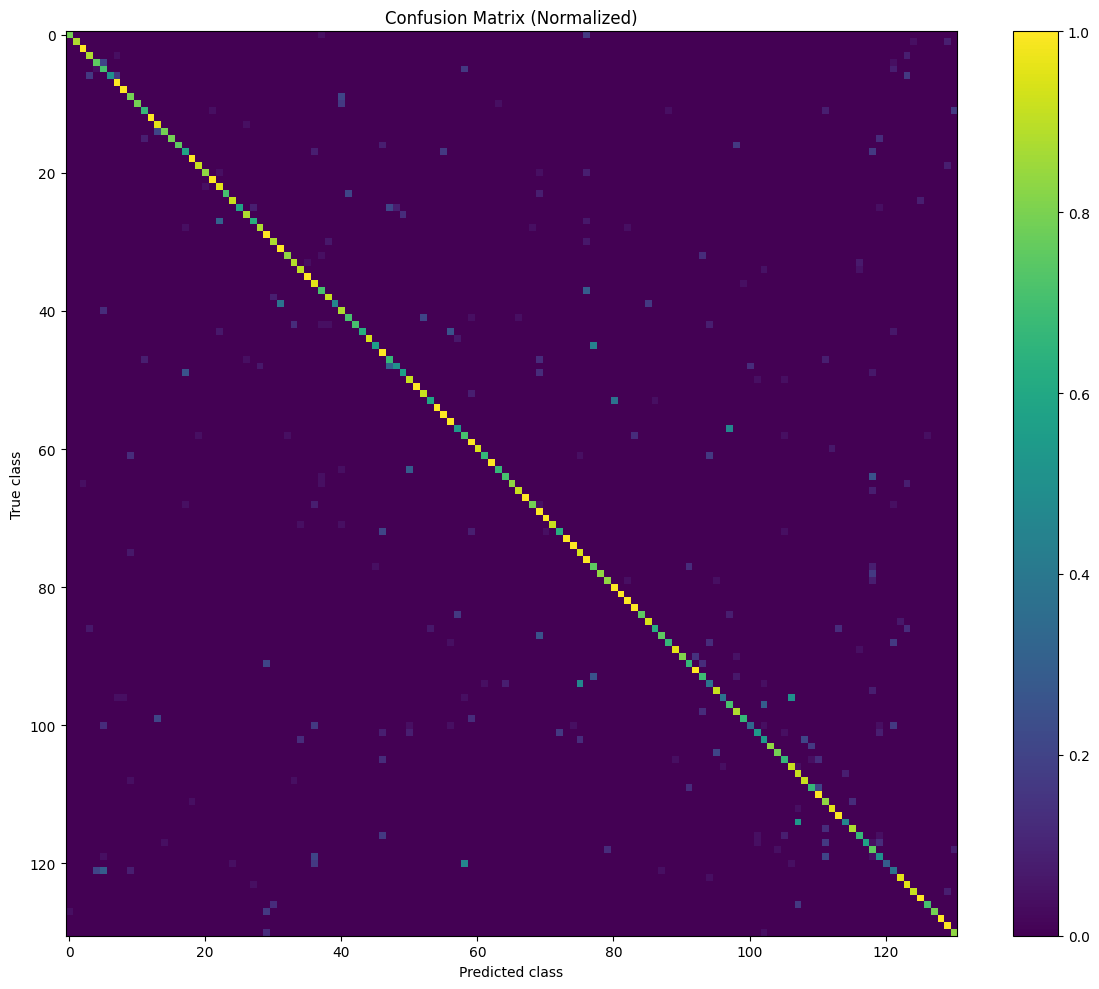

Saved:
 - /kaggle/working/TEST_ALL_cm.pt
 - /kaggle/working/TEST_ALL_cm.csv
 - /kaggle/working/TEST_ALL_cm_norm.png


In [ ]:
def confusion_matrix_from_logits(logits, labels, num_classes: int):
    preds = logits.argmax(dim=1)
    cm = torch.zeros((num_classes, num_classes), dtype=torch.long)
    for t, p in zip(labels.tolist(), preds.tolist()):
        cm[t, p] += 1
    return cm

def save_confusion_matrix(cm, out_dir="/kaggle/working", name_prefix="test_all", normalize=False):
    os.makedirs(out_dir, exist_ok=True)

    #save raw tensor
    pt_path = os.path.join(out_dir, f"{name_prefix}_cm.pt")
    torch.save(cm, pt_path)

    #save CSV
    csv_path = os.path.join(out_dir, f"{name_prefix}_cm.csv")
    np.savetxt(csv_path, cm.cpu().numpy(), delimiter=",", fmt="%d")

    #plot image
    cm_plot = cm.float()
    if normalize:
        row_sum = cm_plot.sum(dim=1, keepdim=True).clamp_min(1.0)
        cm_plot = cm_plot / row_sum  # normalize by true class counts

    png_path = os.path.join(out_dir, f"{name_prefix}_cm{'_norm' if normalize else ''}.png")
    plt.figure(figsize=(12, 10))
    plt.imshow(cm_plot.cpu().numpy(), aspect="auto")
    plt.title("Confusion Matrix" + (" (Normalized)" if normalize else ""))
    plt.xlabel("Predicted class")
    plt.ylabel("True class")
    plt.colorbar()
    plt.tight_layout()
    plt.savefig(png_path, dpi=200)
    plt.show()

    print("Saved:")
    print(" -", pt_path)
    print(" -", csv_path)
    print(" -", png_path)



NUM_CLASSES = 131
device = next(net.parameters()).device

logits_test, labels_test = collect_logits_labels(net, test_loader, device)  # you already have this function
cm_test = confusion_matrix_from_logits(logits_test, labels_test, NUM_CLASSES)

print("CM shape:", cm_test.shape)
print("Confusion matrix (raw counts):")
print(cm_test)  #will be large , can add to report due would not be clear :(

save_confusion_matrix(cm_test, out_dir="/kaggle/working", name_prefix = "TEST_ALL", normalize = False)
save_confusion_matrix(cm_test, out_dir="/kaggle/working", name_prefix = "TEST_ALL", normalize = True)

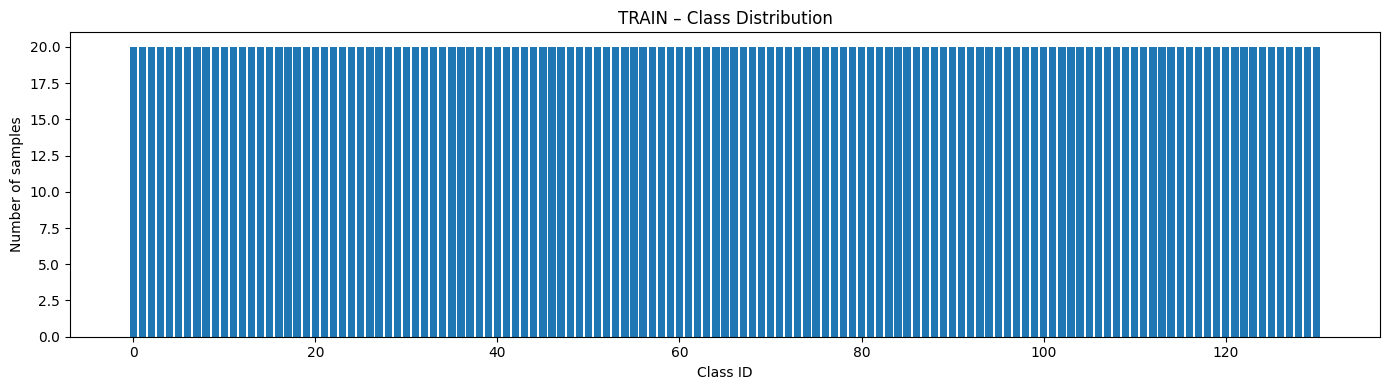

Num classes: 131
Min samples per class: 20
Max samples per class: 20


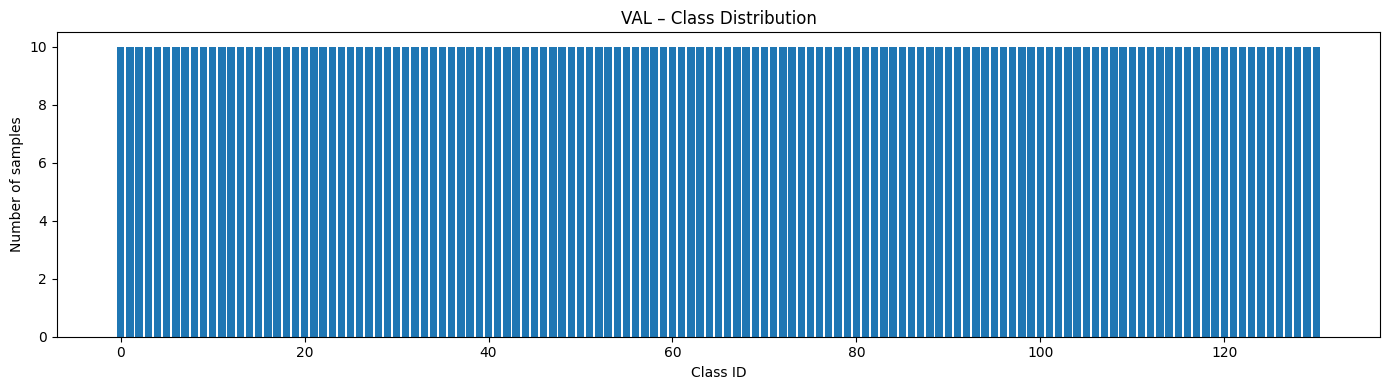

Num classes: 131
Min samples per class: 10
Max samples per class: 10


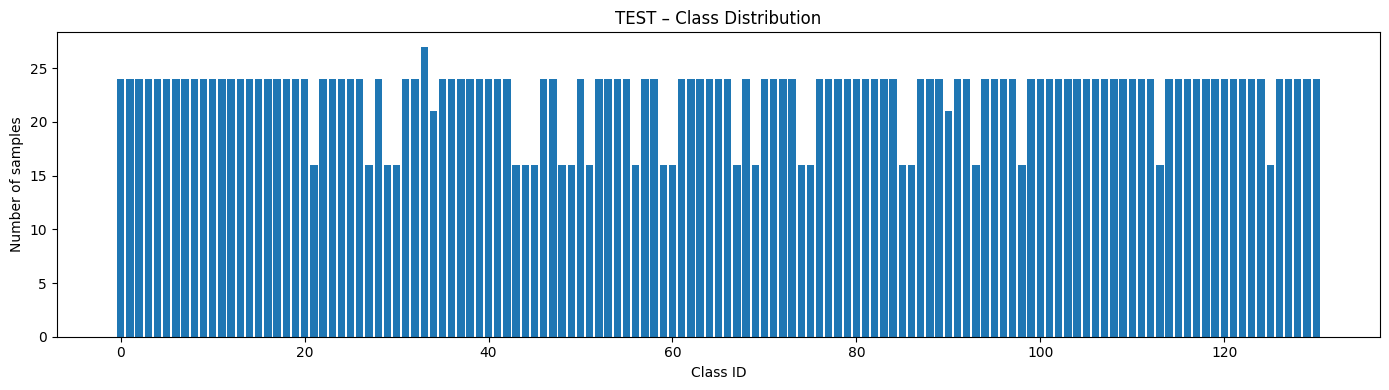

Num classes: 131
Min samples per class: 16
Max samples per class: 27


In [ ]:
import matplotlib.pyplot as plt
from collections import Counter

def plot_class_balance(dataset, title="Class distribution"):
    labels = []
    for i in range(len(dataset)):
        _, y = dataset[i]
        labels.append(int(y))

    cnt = Counter(labels)
    classes = sorted(cnt.keys())
    counts = [cnt[c] for c in classes]

    plt.figure(figsize=(14, 4))
    plt.bar(classes, counts)
    plt.xlabel("Class ID")
    plt.ylabel("Number of samples")
    plt.title(title)
    plt.tight_layout()
    plt.show()

    print(f"Num classes: {len(classes)}")
    print(f"Min samples per class: {min(counts)}")
    print(f"Max samples per class: {max(counts)}")
plot_class_balance(train_ds, "TRAIN – Class Distribution")
plot_class_balance(val_ds,   "VAL – Class Distribution")
plot_class_balance(test_ds,  "TEST – Class Distribution")


In [55]:
def plot_signer_balance(dataset, title="Signer distribution"):
    from collections import Counter
    signers = [signer_from_path(p) for p in dataset.list_key]
    cnt = Counter(signers)

    xs = sorted(cnt.keys())
    ys = [cnt[x] for x in xs]

    plt.figure(figsize=(6, 4))
    plt.bar(xs, ys)
    plt.xlabel("Signer ID")
    plt.ylabel("Number of samples")
    plt.title(title)
    plt.tight_layout()
    plt.show()

    for k in xs:
        print(f"Signer {k:02d}: {cnt[k]} samples")

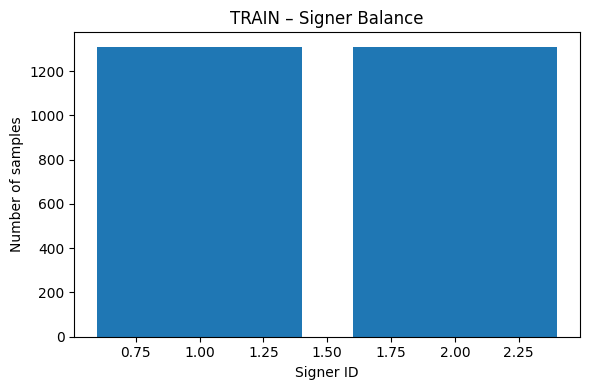

Signer 01: 1310 samples
Signer 02: 1310 samples


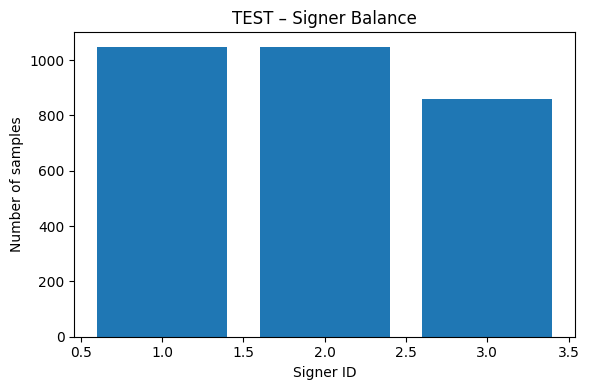

Signer 01: 1048 samples
Signer 02: 1048 samples
Signer 03: 861 samples


In [56]:
plot_signer_balance(train_ds, "TRAIN – Signer Balance")
plot_signer_balance(test_ds,  "TEST – Signer Balance")

In [57]:
def plot_class_balance_per_signer(dataset, signer_id):
    labels = []
    for i, p in enumerate(dataset.list_key):
        if signer_from_path(p) == signer_id:
            _, y = dataset[i]
            labels.append(int(y))

    cnt = Counter(labels)
    classes = sorted(cnt.keys())
    counts = [cnt[c] for c in classes]

    plt.figure(figsize=(14, 4))
    plt.bar(classes, counts)
    plt.xlabel("Class ID")
    plt.ylabel("Samples")
    plt.title(f"Signer {signer_id:02d} – Class Distribution")
    plt.tight_layout()
    plt.show()

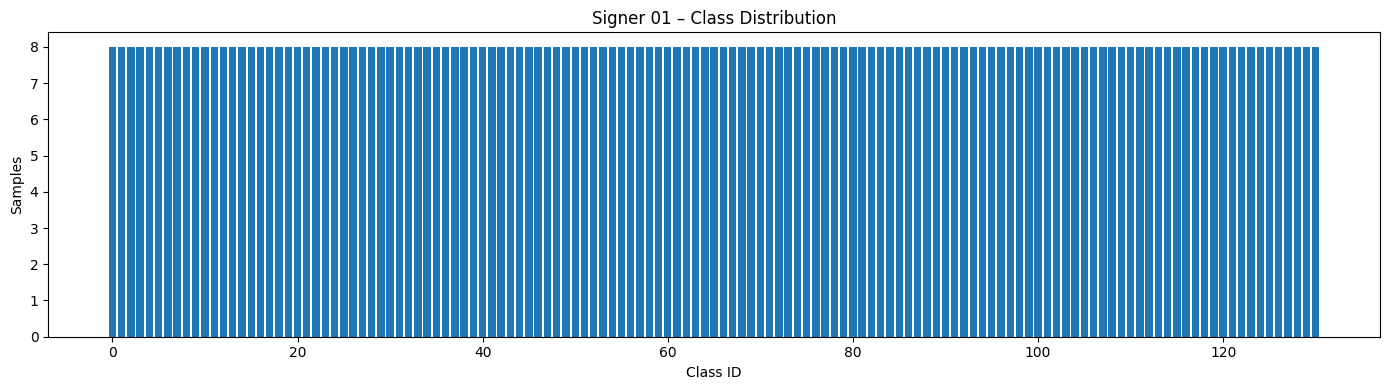

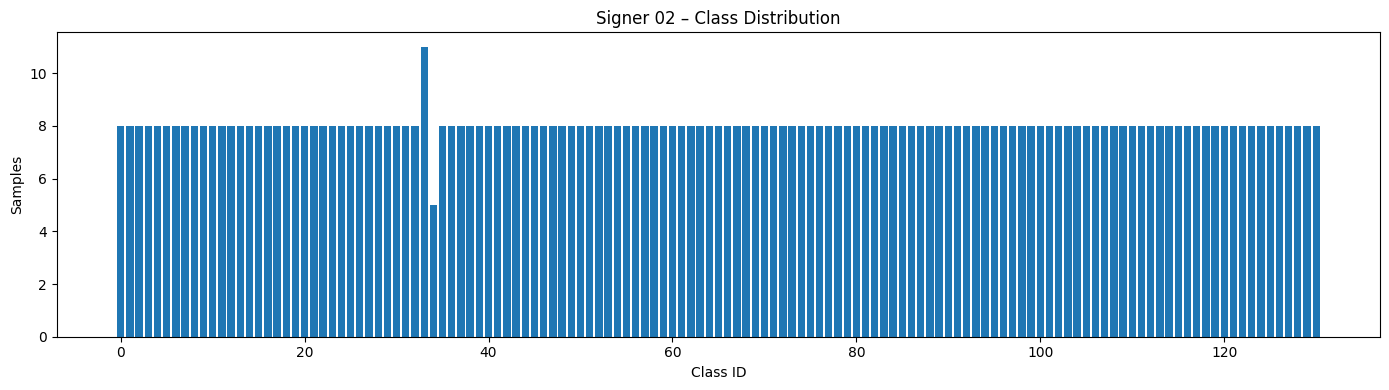

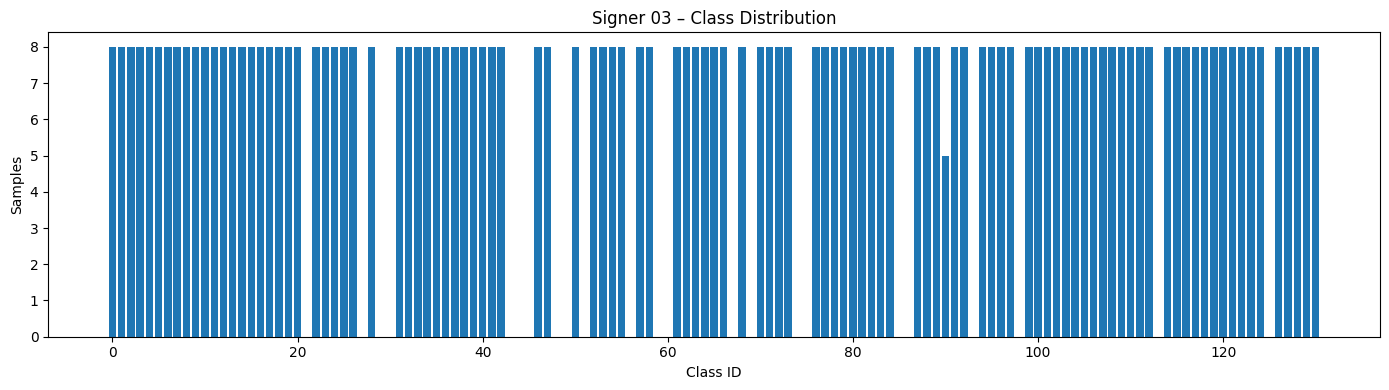

In [58]:
plot_class_balance_per_signer(test_ds, 1)
plot_class_balance_per_signer(test_ds, 2)
plot_class_balance_per_signer(test_ds, 3)

In [59]:
def precision_recall_from_cm(cm):
    tp = cm.diag().float()
    fp = cm.sum(dim=0).float() - tp
    fn = cm.sum(dim=1).float() - tp

    precision = tp / (tp + fp + 1e-12)
    recall    = tp / (tp + fn + 1e-12)

    return precision, recall

In [60]:
precision, recall = precision_recall_from_cm(cm_test)

print("Precision:", precision.mean().item())
print("Recall   :", recall.mean().item())

Precision: 0.8352357745170593
Recall   : 0.8094707727432251
